# Quick testing

In [1]:
import numpy as np

In [2]:
grid = np.zeros((10,10,10))

In [3]:
grid[(1,2)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [4]:
grid = np.zeros((3,2,2))


In [5]:
for index, x in np.ndenumerate(grid):
    print(index)

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)
(2, 0, 0)
(2, 0, 1)
(2, 1, 0)
(2, 1, 1)


In [6]:
pos = (-0.1,.3)
offset = (0.0,0.1)
res = (10,10)
size = (3,3)
new_pos = tuple([int(a*c/b) for a,b,c in zip(pos, size, res)])

## Testing np.where conditions

In [7]:
import numpy as np

walls = np.array([[-1,1], [1,1]])
walls


array([[-1,  1],
       [ 1,  1]])

In [8]:
np.where(walls[:][0]>0, walls[:], -walls[:])

array([[ 1,  1],
       [-1,  1]])

## Testing expr

In [9]:
import numexpr

In [10]:
walls = np.array([[-1,1,1,1], [1,1,1,1]])
arr = np.array([[1,1,1,1,0], [2,1,-1,-1,0]])
print(arr)

[[ 1  1  1  1  0]
 [ 2  1 -1 -1  0]]


In [11]:
dp = walls[:,:2]-walls[:,2:]
# supposing dp.x > 0
ctheta, stheta = dp[:,0], dp[:,1]
x, y, vx, vy, vz = np.split(arr, indices_or_sections=5, axis = 1)
b = numexpr.evaluate("-vx*stheta+vy*ctheta")  # -velocity.x*stheta+velocity.y*ctheta


## Collision with walls

In [1]:
from src.utils import handler_wall_collision, make_collisions, make_collisions_parallel
import numpy as np
N = 100000
walls = np.array([[0,0,1,0], [0,0,0,1], [1,0,1,1], [0,1,1,1]])
a = np.array([[1,0, 1],[0,1, 1],[0,1, 1],[1,0, 1]])
arr =  np.random.random((N,5)) # np.array([[2,0.5,1,0,0], [0.5,2,0,1,0], [2,2,1,1,0], [0.5,0.5,1,0,0], [0.5,0.5,-1,0,0]]*N)
radius = 0.1
print(arr.shape)

(100000, 5)


In [2]:
# Question : is it faster to compute new positions for every particle (and those who got a time collision = 0 which basically will not move)
# or to loop over only those who need to do something ?
# In which case it is better if I replace very inf value by 0.


In [3]:
ct, cp = _handler_wall_collision(arr, walls, a, radius)


In [4]:
new_arr_1 = make_collisions(np.copy(arr), walls, a, ct, cp)
new_arr_2 = make_collisions_parallel(np.copy(arr), walls, a, ct, cp)

In [5]:
#print(arr)
np.array_equal(new_arr_1, new_arr_2)

False

for k in range(len(new_arr_1)):
    if(not np.array_equal(new_arr_1[k], new_arr_2[k])):
        print(f'{k} : {new_arr_1[k]} vs {new_arr_2[k]}') # all of them because of NaN which makes sense (they were initialized outside the system with speed going outward too)

In [6]:
import timeit
%timeit lambda : make_collisions(np.copy(arr), walls, a, ct, cp) # not to sure about this one
%timeit lambda : make_collisions_parallel(np.copy(arr), walls, a, ct, cp)

38.6 ns ± 1.57 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
36.8 ns ± 0.347 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [7]:
from time import time 
from tqdm import tqdm

def perf_N(tries=100):

    N_list = [10, 100, 1000, 10000, 100000]

    walls = np.array([[0,0,1,0], [0,0,0,1], [1,0,1,1], [0,1,1,1]])
    a = np.array([[1,0, 1],[0,1, 1],[0,1, 1],[1,0, 1]])

    radius = 0.1
    L1, L2 = [], []
    
    for N in N_list :
        t1 = 0
        t2 = 0
        for k in tqdm(range(tries)):
            arr = np.random.random((N,5))
            ct, cp = _handler_wall_collision(arr, walls, a, radius)
            arr1 = np.copy(arr)
            arr2 = np.copy(arr)

            tmp = time()
            make_collisions(arr1, walls, a, ct, cp)
            t1+= time()-tmp

            tmp = time()
            make_collisions_parallel(arr2, walls, a, ct, cp)
            t2+= time()-tmp
        L1.append(t1)
        L2.append(t2)
    return N_list, np.array(L1)/tries, np.array(L2)/tries

def perf_walls(tries=100):

    def wall_builders(N):
        split = N//4 
        l = 1.0/split
        walls = []
        a = np.array(split*[[1,0, 1],[0,1, 1],[0,1, 1],[1,0, 1]])
        for k in range(split):
            w1 = [k*split, 0, (k+1)*split, 0]
            w2 = [0, k*split, 0, (k+1)*split]
            w3 = [1, k*split, 1, (k+1)*split]
            w4 = [k*split, 1, (k+1)*split, 1]
            walls.append(w1)
            walls.append(w2)
            walls.append(w3)
            walls.append(w4)
        return np.array(walls), a

    N = 1000
    walls_number = [4, 8, 16, 32, 64, 128]     # we will keep a square

    radius = 0.1
    L1, L2 = [], []
    for nb in walls_number :
        t1 = 0
        t2 = 0
        for k in tqdm(range(tries)):
            arr = np.random.random((N,5))
            walls, a = wall_builders(nb)

            ct, cp = _handler_wall_collision(arr, walls, a, radius)

            arr1 = np.copy(arr)
            arr2 = np.copy(arr)

            tmp = time()
            make_collisions(arr1, walls, a, ct, cp)
            t1+= time()-tmp

            tmp = time()
            make_collisions_parallel(arr2, walls, a, ct, cp)
            t2+= time()-tmp
        L1.append(t1)
        L2.append(t2)
    return walls_number, np.array(L1)/tries, np.array(L2)/tries

100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


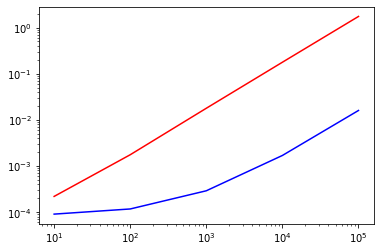

In [8]:
import matplotlib.pyplot as plt
N, L1, L2 = perf_N()

plt.plot(N, L1, 'r')
plt.plot(N, L2, 'b')
plt.yscale('log')
plt.xscale('log')

100%|██████████| 100/100 [00:02<00:00, 37.94it/s]


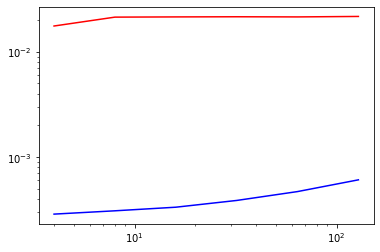

In [9]:
N, L1, L2 = perf_walls() # perf_walls()
import matplotlib.pyplot as plt
plt.plot(N, L1, 'r')
plt.plot(N, L2, 'b')
plt.yscale('log')
plt.xscale('log')


# Performance analysis - date structure to store particles in cells
Needs :
- delete (for advection phase)
- add
- get (for collisisons)

Ideally, we want only $O(1)$

Conclusion : 
While python seems faster than numpy array with the small examples I made, it is because each time we do a *get* or a *add* or a remove, we do not use the fact that the memory is contiguous for numpy array. We do one at a time. Thus, python list is faster by a factor 2 relativley to numpy array.

However as soon as we want to remove several contiguous particles at a time, or get add several contiguous particles, then the numpy array "retake the lead".

For our use case, there is no preference for one or the other. We use both cases even though only on one element most of the time.

However, the advantage of using array numpy comes from the possiblity to easily parallize and cythonize it in the future. If we do that, we should not get too big an overhead while converting and we would go much faster.

In [6]:
from src.utils import LinkedList
import numpy as np
from time import time

In [13]:
class Array(object):
    def __init__(self, shape, dtype = int):
        self.arr = np.empty(shape, dtype = dtype)
        self.init_shape = shape
        self.max_size = shape[0]
        self.elements_nb = 0
        
    def add(self, o):
        if(self.elements_nb >= self.max_size):
            print(f'Max size reach. Changing size from {self.max_size} to {self.max_size+self.init_shape[0]}')
            self.arr = np.concatenate([self.arr, self.empty(shape, dtype = dtype)])
        self.arr[self.elements_nb] = o
        self.elements_nb += 1   

    def add_multiple(self, new_arr):
        if(self.elements_nb+new_arr.shape[0] > self.max_size):
            print(f'Max size reach. Changing size from {self.max_size} to {self.max_size+self.init_shape[0]}')
            self.arr = np.concatenate([self.arr, self.empty(shape, dtype = dtype)])
        self.arr[self.elements_nb:self.elements_nb+new_arr.shape[0]] = new_arr
        self.elements_nb += new_arr.shape[0]   

    def remove(self, idx):
        self.elements_nb -= 1
        self.arr[idx] = self.arr[self.elements_nb]
    # we dont do remove multiple as we will never use it in practice
    def get(self, idx):
        return self.arr[idx]

class PythonList(object):
    def __init__(self):
        self.arr = []
        self.elements_nb = 0
        
    def add(self, o):
        self.arr.append(o)
        self.elements_nb += 1   
    
    def remove(self, idx):
        self.elements_nb -= 1
        self.arr.pop(idx)
    
    def get(self, idx):
        return self.arr[idx]

In [3]:
arr = Array((1000,2)) # max size is 1000
linkedlist = LinkedList()
mylist = PythonList()

In [4]:
def test_add(particle, structure):
    structure.add(particle)

In [43]:
import timeit
part = np.array([1,1], dtype = int)
%timeit lambda : arr.add(part)
%timeit lambda : linkedlist.insert(part)
%timeit lambda : mylist.add(part)

37.8 ns ± 0.609 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
37.7 ns ± 0.519 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
37.3 ns ± 0.46 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [5]:
particles = np.random.randint(low=0, high = 100, size = (500,2), dtype = int)
for part in particles:
    arr.add(part)
    linkedlist.insert(part)
    mylist.add(part)

In [6]:
particles[100]

array([84, 22])

In [7]:
%timeit lambda : arr.get(100)
%timeit lambda : linkedlist.get(100)
%timeit lambda : mylist.get(100)

36.4 ns ± 0.2 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
36.4 ns ± 0.25 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
36.7 ns ± 0.336 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [26]:
%timeit lambda : arr.remove(100)
%timeit lambda : linkedlist.remove(array([ 4, 52]))
%timeit lambda : mylist.remove(100)

34.7 ns ± 0.571 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
36.1 ns ± 0.449 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
34.5 ns ± 0.176 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [9]:
from time import time

t0 = time()
t1 = t0
for k in range(100000):
    tmp = time()
    mylist.get(100)
    t1 += time()-tmp
print(t1-t0)

t0 = time()
t1 = t0

for k in range(100000):
    tmp = time()
    arr.get(100)
    t1 += time()-tmp

print(t1-t0)

t0 = time()
t1 = t0
for k in range(100000):
    tmp = time()
    linkedlist.get(100)
    t1 += time()-tmp

print(t1-t0)

0.01789093017578125
0.03129291534423828
1.0212228298187256


In [7]:
from time import time

t0 = time()
t1 = t0
for k in range(100000):
    mylist.add(np.array([10,10]))
    tmp = time()
    mylist.remove(100)
    t1+=time()-tmp
print(t1-t0)

t0 = time()
t1 = t0
for k in range(100000):
    arr.add(np.array([10,10]))
    tmp = time()
    arr.remove(100)
    t1+=time()-tmp
print(t1-t0)

t0 = time()
t1 = t0
for k in range(100000):
    linkedlist.insert(np.array([10,10]))
    tmp = time()
    linkedlist.remove(100)
    t1+=time()-tmp
print(t1-t0)

0.03703165054321289
0.062259674072265625
1.1104795932769775


In [12]:
particles_list = [part for part in particles]
t0 = time()
t1 = t0
for k in range(100000):
    tmp = time()
    particles_list[100:200]
    t1 += time()-tmp
print(t1-t0)

t0 = time()
t1 = t0

for k in range(100000):
    tmp = time()
    particles[100:200]
    t1 += time()-tmp

print(t1-t0)

0.04170036315917969
0.024298667907714844


# Add multiple

In [7]:
t0 = time()
t1 = t0
for k in range(100000):
    tmp = time()
    for part in particles:
        mylist.add(part)
    t1 += time()-tmp
    for k in range(len(particles)):
        mylist.remove(0)
print(t1-t0)

t0 = time()
t1 = t0

for k in range(100000):
    tmp = time()
    arr.add_multiple(particles)
    t1 += time()-tmp
    for k in range(len(particles)):
        arr.remove(0)
print(t1-t0)

15.703728914260864
0.1593465805053711


# Testing injector 

In [1]:
from src.utils import inject 
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

In [22]:
# Signature : inject(in_wall, in_vect, debit, vel_std, radius, dt)
in_wall =  np.array([0,0,1,1]) # np.array([0,0,0,1]) # np.array([0,0,1,0]) # np.array([0,0,0,1]) # np.array([0,0,1,1])
in_vect =  (1/np.sqrt(2))*np.array([-1,1]) # -np.array([1,0]) #  -np.array([0,1]) # np.array([1,0])# (1/np.sqrt(2))*np.array([1,1])
debit = 10000000 # particles / s
dt = 0.001
vel_std = 200. # m/s
radius = 0.1

In [23]:
arr, contains = inject(in_wall, in_vect, debit, vel_std, radius, dt)

In [24]:
df = pd.DataFrame(arr, columns = ['x', 'y', 'vx', 'vy', 'vz'])

In [25]:
#ProfileReport(df)

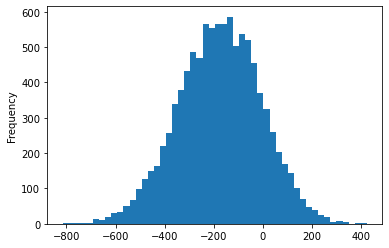

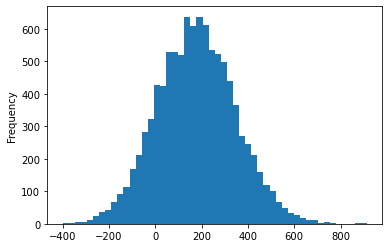

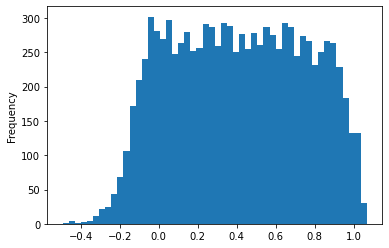

<AxesSubplot:ylabel='Frequency'>

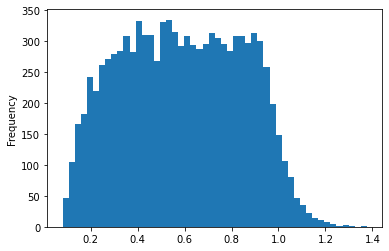

In [26]:
df['vx'].plot.hist(bins=50)
plt.show()
df['vy'].plot.hist(bins=50)
plt.show()
df['x'].plot.hist(bins=50)
plt.show()
df['y'].plot.hist(bins=50)

# Advection phase

In [23]:
from src.utils import advect
from src.utils import euler_explicit, leap_frog

import numpy as np

In [24]:
# signature : advect(arr, f, dt, args, scheme)
arr = np.array([[1,1,1,1,0], [2,1,-1,-1,0]], dtype = float)

def f(arr, dt):
    return np.zeros(shape = (arr.shape[0], 3))

In [25]:
arr_ = advect(arr, f, dt = 0.1, args = [], scheme = euler_explicit) # seems ok

In [26]:
arr_, acc = advect(arr, f, dt = 0.1, args = [], scheme = leap_frog) # seems ok

# Integration test

In [1]:
# system
from src.system_creator import SystemCreator

# Grid
from src.utils import Grid, pos_in_grid

# Particles
from src.utils import Particle

# injection 
from src.utils import inject

# advection
from src.utils import advect
from src.utils import euler_explicit, leap_frog

# collisions
from src.utils import handler_wall_collision, make_collisions_vectorized

# utils 
from src.utils import gaussian, maxwellian_flux, maxwellian_mean_speed, get_mass_part

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Signatures :
 - SystemCreator(segments)
 - inject(in_wall, in_vect, debit, vel_std, radius, dt, remains)
 - advect(arr, f, dt, args, scheme)
 - handler_wall_collision(arr, walls, a, radius)
 - make_collisions_vectorized(arr, a, ct, cp)
 - Particle(part_type, charge, mass, radius, size_array)
 - Grid(resolutions, max_number_per_cell)

In [2]:
iterations = 1000

# System :
dz = 0.001
segments = 0.001*np.array([[0,0,10,0], [0,0,0,1], [10,0,10,1], [0,1,10,1]])
system = SystemCreator(segments)

offsets = system.get_offsets()
system_shape = system.system_shape()
a = system.get_dir_vects()

# grid :
mean_number_per_cell = 10
max_number_per_cell = 10*mean_number_per_cell
resolutions = np.array((10,100), dtype = int)
grid = Grid(resolutions, max_number_per_cell)

# Particles - 1 type 
density = 3.2e19 # m-3
n_simu = mean_number_per_cell*np.sum(resolutions)
n_real = dz * system_shape[0] * system_shape[1] * density
mr = n_real/n_simu# macro particules ratio = number of particles in the real system / number of macro part in the simulated system
density_dsmc = density/mr
temperature = 300 # K

part_type = 'I'
charge, mass, radius = 0, get_mass_part(53, 53, 74), 2e-10
size_array = 2*max_number_per_cell*np.sum(resolutions)
v_mean = maxwellian_mean_speed(temperature, mass)
container = Particle(part_type, charge, mass, radius, size_array)

# Injection params
in_wall = np.array([0,0,0,0.001], dtype = float)
in_vect = np.array([1,0], dtype = float)
debit = maxwellian_flux(density_dsmc, v_mean)*np.linalg.norm(in_wall[:2]-in_wall[2:])*dz
vel_std = gaussian(temperature, mass)
dt = 1e-6

# advection
def f(arr, dt):
    return np.zeros(shape = (arr.shape[0], 3))
args = []
scheme = euler_explicit

In [3]:
def plot_system(ax, system):
    for segment in system.get_segments():
        ax.plot([segment[0], segment[2]],[segment[1], segment[3]], color = 'k')
    
def plot_particles(ax, arr):
    ax.scatter(arr[:,0], arr[:,1])

def plot(arr, system):
    fig, ax = plt.subplots(figsize = (10,10))
    plot_system(ax, system)
    plot_particles(ax, arr)
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]/home/paul/Documents/projects/lppydsmc/src/utils/wall_collision.py:103: RuntimeWarning: overflow encountered in true_divide
  np.divide((-a_prime-radius), b, out=t_coll_1, where=b!=0)
/home/paul/Documents/projects/lppydsmc/src/utils/wall_collision.py:104: RuntimeWarning: overflow encountered in true_divide
  np.divide((-a_prime+radius), b, out=t_coll_2, where=b!=0)
/home/paul/Documents/projects/lppydsmc/src/utils/wall_collision.py:124: RuntimeWarning: invalid value encountered in multiply
  arr[:,0] = cp[:,0]+ct*arr[:,2] # new x pos
/home/paul/Documents/projects/lppydsmc/src/utils/wall_collision.py:125: RuntimeWarning: invalid value encountered in multiply
  arr[:,1] = cp[:,1]+ct*arr[:,3] # new y pos


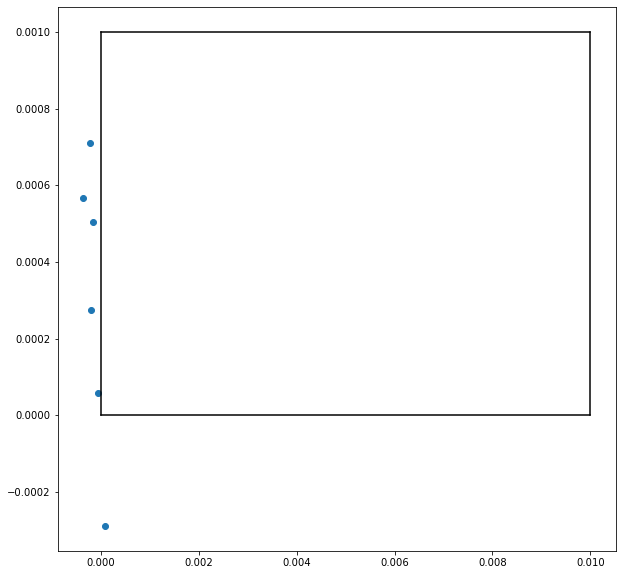

 10%|▉         | 96/1000 [00:00<00:06, 148.30it/s]

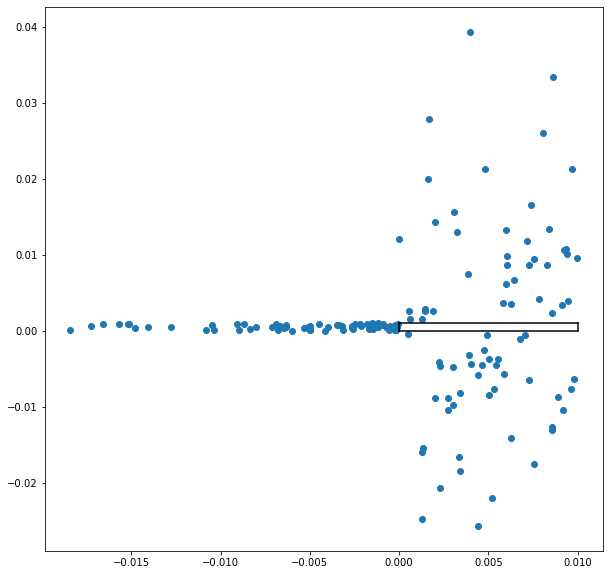

 19%|█▊        | 187/1000 [00:01<00:05, 140.65it/s]

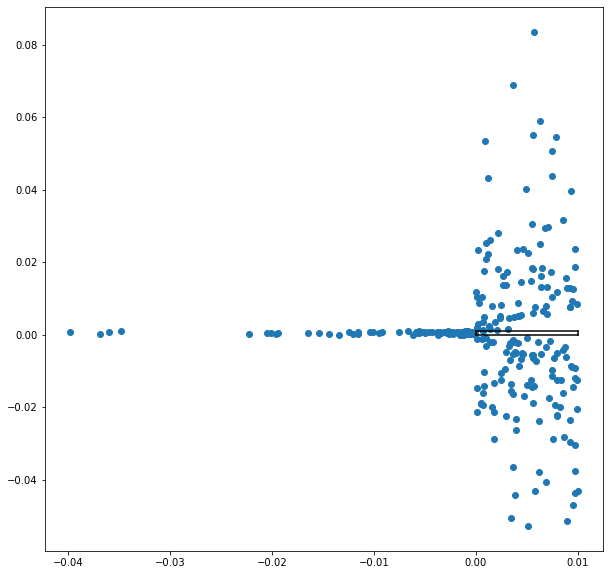

 30%|██▉       | 298/1000 [00:02<00:04, 147.13it/s]

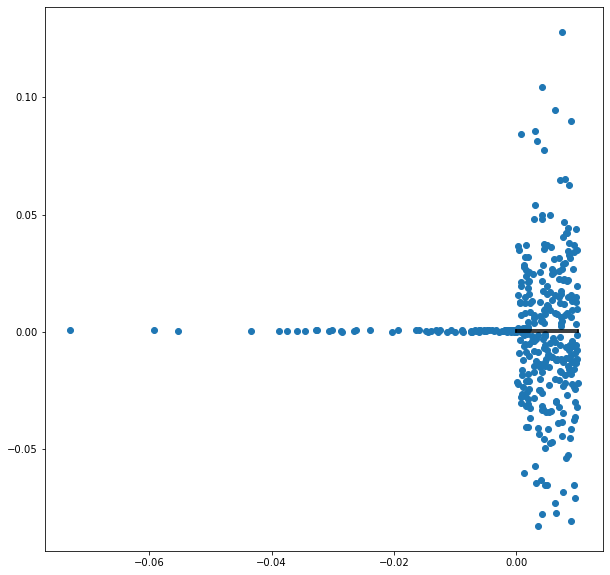

 39%|███▉      | 391/1000 [00:02<00:04, 142.67it/s]

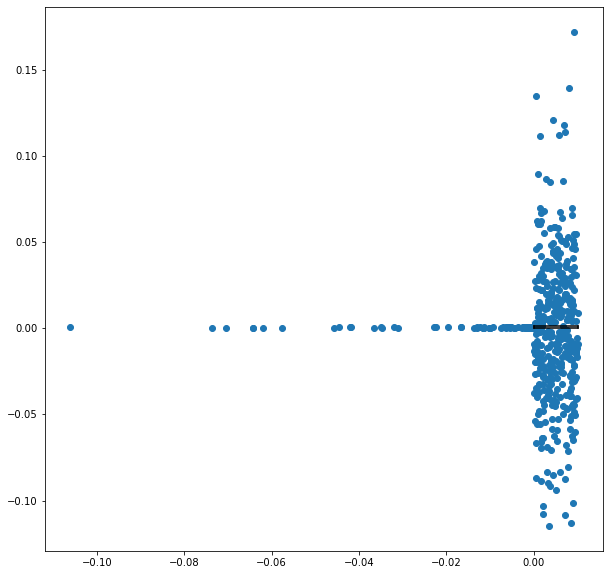

 43%|████▎     | 433/1000 [00:03<00:04, 128.82it/s]


could not broadcast input array from shape (3,2) into shape (0,2)
Max : 100
 pos : 
 [ 0 96] 
 current : 
 100 
 shape o : 
 3
[]


ValueError: 

In [4]:
remains = 0
for it in tqdm(range(iterations)):
    # injecting particles
    new, remains = inject(in_wall, in_vect, debit, vel_std, radius, dt, remains)
    # adding them to the container for particles
    current_save = container.get_current()
    
    container.add_multiple(new)
    pos_in_grids = pos_in_grid(new[:,:2], resolutions, offsets, system_shape)
    index_container = np.zeros(( container.get_current()-current_save ))
    index_in_container = np.arange(current_save, container.get_current())
    indexes = np.stack( (index_container, index_in_container), axis = 1)
    # print(f'\n pos in grids : \n {pos_in_grids} \n indexes : \n {indexes}')
    grid.add_multiple(np.concatenate((pos_in_grids, indexes), axis = 1))

    # advecting
    arr = container.get_particles()
    arr = advect(arr, f, dt, args, scheme)

    # collisions
    ct, cp = handler_wall_collision(arr, segments, a, radius)
    arr = make_collisions_vectorized(arr, a, ct, cp)

    if(it%100==0):
        plot(arr, system)

In [4]:
pos = np.array([[0.001,0.0001], [0.005,0.0002], [0.001,0.0005]])
print(pos.shape)
grid_res = np.array([100,10])
system_shape = np.array([0.01,0.001])
np.floor(np.subtract(pos,offsets)*grid_res/system_shape).astype(int)

(3, 2)


array([[10,  1],
       [50,  2],
       [10,  5]])

In [5]:
np.ceil(-0.2)

-0.0

In [4]:
grid.current.shape

(10, 100)

In [7]:
grid.add((1,1), np.array([0,1]))

grid.

In [24]:
pos = np.array([[1,1], [2,2]])


array([array([[0, 0],
              [0, 0],
              [0, 0],
              ...,
              [0, 0],
              [0, 0],
              [0, 0]]), array([[0, 0],
                               [0, 0],
                               [0, 0],
                               ...,
                               [0, 0],
                               [0, 0],
                               [0, 0]])], dtype=object)

In [9]:
grid.add_multiple(pos = np.array([[1,1], [2,2]]).astype(int), o = np.array([[0,1], [0,2]]))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [11]:
type(np.array([[1,1], [2,2]]).astype(int)[0,0])

numpy.int64

In [19]:
grid_ = np.empty([10,10], dtype = np.ndarray)
current = np.zeros((10,10), dtype = int)

In [20]:
for lx in range(10):
            for ly in range(10):
                grid_[lx,ly]=np.empty((20, 2), dtype = int)
                

In [26]:
current[np.array([[1,1],[2,2]])]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [ ]:
self.arr[np.array([[1,1], [2,2]]).astype(int), self./]

In [9]:
a = np.array([[1,1],[1,1], [2,1], [2,2], [0,1], [2,2]])
store = np.array([[0,1],[0,2], [0,3], [0,4], [0,5], [0,6]])
b = np.concatenate((a,store), axis = 1)
b = np.sort(b.view('i8,i8,i8,i8'), order = ['f1','f2'], axis = 0).view(int)
print(b)

[[0 1 0 5]
 [1 1 0 1]
 [1 1 0 2]
 [2 1 0 3]
 [2 2 0 4]
 [2 2 0 6]]


In [10]:
unique_pos_in_grids, index = np.unique(b[:,:2], return_index = True, axis = 0)

In [11]:
index

array([0, 1, 3, 4])

In [12]:
unique_pos_in_grids

array([[0, 1],
       [1, 1],
       [2, 1],
       [2, 2]])

In [17]:
l = len(unique_pos_in_grids)
print(l)
for k in range(1, l):
    pos = unique_pos_in_grids[k-1]
    o = b[index[k-1]:index[k], 2:]
    print(f'{k} : pos = {pos}, objects = {o}')
pos = unique_pos_in_grids[l-1]
o = b[index[l-1]:, 2:]
print(f'{l-1} : pos = {pos}, objects = {o}')


4
1 : pos = [0 1], objects = [[0 5]]
2 : pos = [1 1], objects = [[0 1]
 [0 2]]
3 : pos = [2 1], objects = [[0 3]]
3 : pos = [2 2], objects = [[0 4]
 [0 6]]
